In [1]:
# all the necessary code for building the pipeline is provided here just create a pipeline flow
# the code for loading pretrained models
# it should take previous atleast 7 days data (tweets and tabular) of previous week or predict just 'adj close' of next week so give me the prediction code 
# integrate SHAP XAI here for XGBoost

2025-05-11 06:48:18.597821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746946098.776260      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746946098.828876      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.00batch/s]
X has feature names, but StandardScaler was fitted without feature names


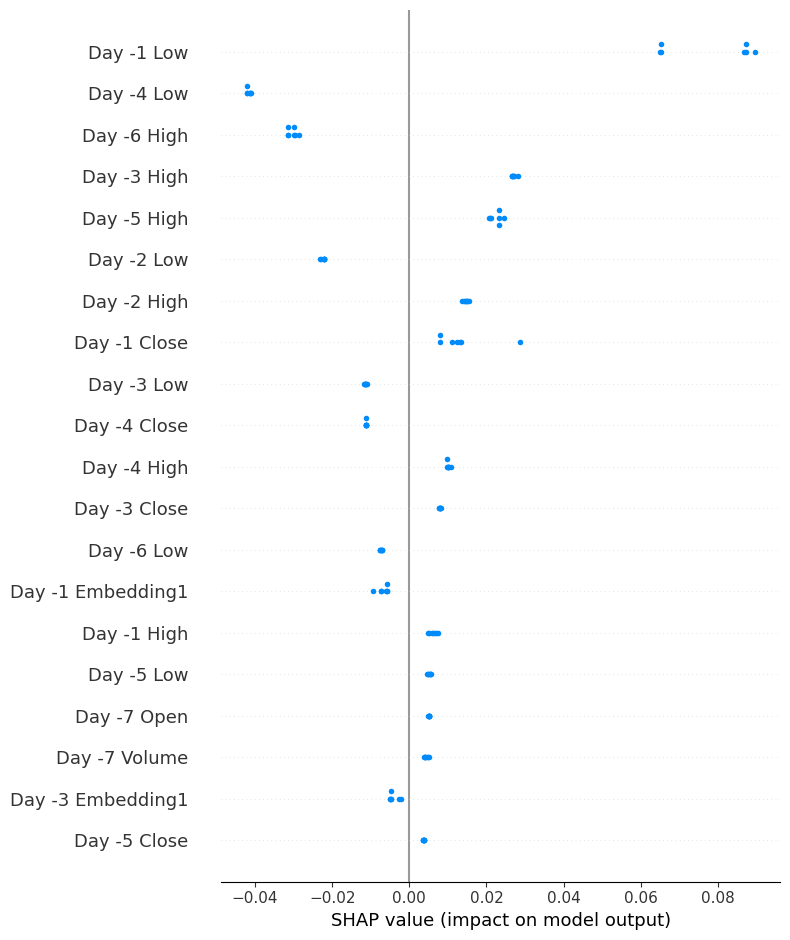

Top 5 most important features across predictions:
Day -1 Low
Day -4 Low
Day -6 High
Day -3 High
Day -5 High
        Date  Predicted Adj Close
0 2019-01-08          3993.880259
1 2019-01-09          3868.247539
2 2019-01-10          3875.744564
3 2019-01-11          3853.096845
4 2019-01-12          3726.825208
5 2019-01-13          3704.574142
6 2019-01-14          3706.295170


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import joblib
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import re
import shap
import matplotlib.pyplot as plt

# Load pre-trained models
pca_model = joblib.load('/kaggle/input/multiple/pytorch/default/1/pca_model.joblib')
X_scaler = joblib.load('/kaggle/input/multiple/pytorch/default/1/X_scaler.joblib')
y_scaler = joblib.load('/kaggle/input/multiple/pytorch/default/1/y_scaler.joblib')
xgb_model = joblib.load('/kaggle/input/multiple/pytorch/default/1/xgb_model.joblib')

# Load BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertModel.from_pretrained(
    "bert-base-uncased",
    torch_dtype=torch.float16 if device.type == "cuda" else torch.float32
).to(device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# cleaning text
def clean_tweet(text):
    if isinstance(text, str):
        text = re.sub(r"http\S+|@\S+|#\S+", "", text)
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        return text.strip()
    return ""

def generate_embeddings(text_series):
    texts = text_series.tolist()
    embeddings = []
    batch_size = 2
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings", unit="batch"):
        batch_texts = texts[i:i+batch_size]
        cleaned_batch = [t.replace('\n', ' ').strip()[:128] for t in batch_texts]
        inputs = bert_tokenizer(
            cleaned_batch,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt"
        )
        with torch.autocast(device_type=device.type, dtype=torch.float16):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = bert_model(**inputs)
        batch_emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_emb)
        del inputs, outputs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return np.array(embeddings).astype(np.float16)

# creating new dfs
df_new_tweets = pd.read_csv("/kaggle/input/test-data-for-pipeline/tweets_data_test.csv", parse_dates=["timestamp"])
df_new_prices = pd.read_csv("/kaggle/input/test-data-for-pipeline/prices_data_test.csv", parse_dates=["Date"])

# checking last date
date_T = df_new_prices['Date'].max()
start_date = date_T - timedelta(days=6)

# Filter data
df_new_prices = df_new_prices[(df_new_prices['Date'] >= start_date) & (df_new_prices['Date'] <= date_T)]
df_new_prices = df_new_prices.sort_values('Date')

df_new_tweets = df_new_tweets[(df_new_tweets['timestamp'].dt.date >= start_date.date()) & (df_new_tweets['timestamp'].dt.date <= date_T.date())]

# Clean tweets
df_new_tweets['text'] = df_new_tweets['text'].apply(clean_tweet)

# Aggregate tweets daily
daily_tweets_new = df_new_tweets.groupby(df_new_tweets['timestamp'].dt.date).agg({
    'text': lambda x: ' '.join(x)
}).reset_index()
daily_tweets_new['Date'] = pd.to_datetime(daily_tweets_new['timestamp'])
daily_tweets_new = daily_tweets_new.drop(columns=['timestamp'])

# Generate embeddings
embeddings = generate_embeddings(daily_tweets_new['text'])
daily_tweets_new['embeddings'] = list(embeddings)

# Align with prices
df_aligned = pd.merge(
    df_new_prices,
    daily_tweets_new[['Date', 'embeddings']],
    on='Date',
    how='left'
)
df_aligned['embeddings'] = df_aligned['embeddings'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(768))

# Get tabular data
tabular_new = df_aligned[['Open', 'High', 'Low', 'Close', 'Volume']]
tabular_new_scaled = X_scaler.transform(tabular_new)

# Get embeddings matrix
embeddings_list = df_aligned['embeddings'].tolist()
embeddings_matrix = np.vstack([emb if isinstance(emb, np.ndarray) else np.zeros(768) for emb in embeddings_list])
reduced_embeddings = pca_model.transform(embeddings_matrix)

# Combine features
X_combined_new = np.hstack([tabular_new_scaled, reduced_embeddings])

# Initialize past_X
past_X = [row for row in X_combined_new]

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Predictions list and SHAP values
predictions = []
all_shap_values = []

for m in range(1, 8):
    seq = past_X[-7:]
    X_seq = np.array(seq).reshape(1, -1)  # Shape (1, 49)
    
    # Make prediction
    y_pred_scaled = xgb_model.predict(X_seq)[0]
    y_pred = y_scaler.inverse_transform([[y_pred_scaled]])[0, 0]
    predictions.append(y_pred)
    
    # Compute SHAP values
    shap_values = explainer(X_seq)
    all_shap_values.append(shap_values)
    
    # Construct next X_day
    if m == 1:
        Open_next = df_aligned['Close'].iloc[-1]
    else:
        Open_next = predictions[m-2]
    Close_next = y_pred
    High_next = max(Open_next, Close_next)
    Low_next = min(Open_next, Close_next)
    Volume_next = df_aligned['Volume'].mean()
    tabular_next = [Open_next, High_next, Low_next, Close_next, Volume_next]
    tabular_scaled_next = X_scaler.transform([tabular_next])[0]
    embeddings_next = np.zeros(768)
    reduced_next = pca_model.transform([embeddings_next])[0]
    X_day_next = np.hstack([tabular_scaled_next, reduced_next])
    past_X.append(X_day_next)

# Extract SHAP values from Explanation objects
shap_values_array = np.vstack([shap.values for shap in all_shap_values])

# Define feature names
feature_names = []
for d in range(7, 0, -1):
    day = f"Day -{d}"
    for feat in ["Open", "High", "Low", "Close", "Volume", "Embedding1", "Embedding2"]:
        feature_names.append(f"{day} {feat}")

# Plot SHAP summary
shap.summary_plot(shap_values_array, feature_names=feature_names)
plt.savefig("shap_summary.png")
plt.close()

# Compute mean absolute SHAP values
mean_abs_shap = np.mean(np.abs(shap_values_array), axis=0)

# Print top 5 most important features
top_features_idx = np.argsort(-mean_abs_shap)[:5]
top_features = [feature_names[i] for i in top_features_idx]
print("Top 5 most important features across predictions:")
for feat in top_features:
    print(feat)

# Create future dates and predictions DataFrame
dates_future = [date_T + timedelta(days=k) for k in range(1, 8)]
df_predictions = pd.DataFrame({'Date': dates_future, 'Predicted Adj Close': predictions})

# Print and save predictions
print(df_predictions)
df_predictions.to_csv("predictions.csv", index=False)